In [97]:
!pip install finance-datareader

In [98]:
import FinanceDataReader as fdr
import tensorflow as tf
import numpy as np

In [99]:
# 과거 5년(365일 x 5년) + 1일의 총 일수를 계산
days = 365 * 5 + 1

# FinanceDataReader를 사용하여 특정 주식의 데이터를 가져옴
# '069500'은 한국의 KODEX 200 ETF를 의미함
# 이 코드는 해당 ETF의 최근 5년간의 종가 데이터를 가져옴
series = fdr.DataReader('069500').Close.tail(days)

# 종가 데이터를 최대값으로 나누어 정규화
# 이는 모든 값을 0과 1 사이의 범위로 조정하여 데이터의 스케일을 통일함
series = series / np.max(series)

# 시간 배열 생성
# np.arange 함수를 사용하여 0부터 'days'까지의 연속된 정수 배열을 생성
# 이 배열은 시계열 데이터의 각 포인트에 대응하는 시간 축을 나타냄
time = np.arange(days)

In [100]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # TensorFlow의 Dataset API를 사용하여 series 데이터를 Dataset 객체로 변환
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # 데이터셋을 윈도우로 분할
    # window_size + 1 크기의 윈도우를 생성하고, 매번 1 스텝씩 이동
    # drop_remainder=True는 윈도우 크기가 정확히 맞지 않을 경우 마지막 부분을 제거함
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # 각 윈도우를 평평하게 만들어줌 (flat_map)
    # window.batch(window_size + 1)를 통해 각 윈도우 내의 요소들을 배치로 묶음
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # 데이터셋을 섞음
    # shuffle_buffer는 섞는 과정에서 사용할 버퍼의 크기를 지정
    dataset = dataset.shuffle(shuffle_buffer)

    # 각 윈도우에서 마지막 요소를 제외한 나머지를 입력(x), 마지막 요소를 출력(y)으로 설정
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # 데이터셋을 지정된 배치 크기로 묶음
    dataset = dataset.batch(batch_size)

    # 데이터셋의 성능을 향상시키기 위해 prefetch 사용
    # 이는 훈련 중

In [101]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [102]:
# 전체 데이터 길이에서 365를 빼서 훈련 데이터와 검증 데이터를 분할할 시점을 결정합니다.
split_time = len(series) - 365

# 시간 데이터에서 훈련 데이터에 해당하는 부분을 추출합니다.
time_train = time[:split_time]

# 시계열 데이터에서 훈련 데이터에 해당하는 부분을 추출합니다.
x_train = series[:split_time]

# 시간 데이터에서 검증 데이터에 해당하는 부분을 추출합니다.
time_valid = time[split_time:]

# 시계열 데이터에서 검증 데이터에 해당하는 부분을 추출합니다.
x_valid = series[split_time:]

# 윈도우 크기를 설정합니다. 이는 각 훈련 샘플에서 고려할 이전 시간 단계의 수를 정의합니다.
window_size = 30

# 배치 크기를 설정합니다. 이는 모델 훈련 시 각 배치에 포함될 샘플 수를 정의합니다.
batch_size = 32

# 셔플 버퍼 크기를 설정합니다. 이는 데이터 셔플링 시 사용될 메모리 크기를 정의합니다.
shuffle_buffer_size = len(series) - 365

# 훈련 데이터셋을 생성합니다. 이 함수는 시계열 데이터를 윈도우로 나누고 배치로 구성합니다.
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# 검증 데이터셋을 생성합니다. 동일한 방식으로 검증 데이터도 윈도우로 나누고 배치로 구성합니다.
valid_dataset = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

In [103]:
# 순차 모델을 생성합니다. 이 모델은 레이어를 순차적으로 쌓아 구성됩니다.
model = Sequential([
    # 첫 번째 SimpleRNN 레이어를 추가합니다. 64개의 뉴런을 가지며, 다음 레이어로 시퀀스를 반환합니다.
    # input_shape은 입력 데이터의 형태를 정의합니다. 여기서는 시퀀스의 길이에 상관없이 하나의 특성을 가진다고 정의합니다.
    ,

    # 두 번째 SimpleRNN 레이어를 추가합니다. 이 레이어도 64개의 뉴런을 가집니다.
    # return_sequences=True가 없으므로 마지막 시퀀스만 반환합니다.
    ,

    # Dense 레이어는 출력 레이어로, 하나의 뉴런을 가집니다. 이 레이어는 최종 예측 값을 생성합니다.
    Dense(1),
])

# 모델의 요약 정보를 출력합니다. 이를 통해 모델의 각 레이어와 파라미터 수를 확인할 수 있습니다.
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_26 (SimpleRNN)   (None, None, 64)          4224      
                                                                 
 simple_rnn_27 (SimpleRNN)   (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 12545 (49.00 KB)
Trainable params: 12545 (49.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [108]:
# Keras에서 Adam 옵티마이저를 임포트합니다. Adam은 효율적인 확률적 최적화 알고리즘입니다.
from keras.optimizers import Adam

# Huber 손실 함수를 임포트합니다. Huber 손실은 평균 절대 오차(MAE)와 평균 제곱 오차(MSE)의 조합으로,
# 이상치에 덜 민감합니다.
from keras.losses import Huber

# Adam 옵티마이저를 초기화합니다. 학습률을 0.001 (또는 1e-3)으로 설정합니다.
optimizer = Adam(learning_rate=0.001)

# 모델을 컴파일합니다. Huber 손실 함수를 사용하고, 최적화기로 Adam을 설정합니다.
# 메트릭으로 평균 절대 오차(MAE)를 사용합니다. MAE는 예측값과 실제값의 절대적인 차이를 측정합니다.
model.compile(loss=, optimizer=optimizer, metrics=['mae'])

# 모델을 훈련합니다. 훈련 데이터셋으로 'dataset'을 사용하고, 에폭 수를 50으로 설정합니다.
# verbose=1은 훈련 과정 중 상태 업데이트를 출력합니다.
# 검증 데이터셋으로 'valid_dataset'을 사용합니다.
history = model.fit(dataset, epochs=50, verbose=1, validation_data=valid_dataset)

Epoch 1/50
45/45 [==============================] - 4s 44ms/step - loss: 0.0085 - mae: 0.0813 - val_loss: 4.4883e-04 - val_mae: 0.0278
Epoch 2/50
45/45 [==============================] - 2s 37ms/step - loss: 1.0488e-04 - mae: 0.0110 - val_loss: 6.0808e-05 - val_mae: 0.0088
Epoch 3/50
45/45 [==============================] - 2s 36ms/step - loss: 6.9189e-05 - mae: 0.0085 - val_loss: 5.7920e-05 - val_mae: 0.0087
Epoch 4/50
45/45 [==============================] - 2s 36ms/step - loss: 6.6162e-05 - mae: 0.0084 - val_loss: 6.2841e-05 - val_mae: 0.0091
Epoch 5/50
45/45 [==============================] - 2s 36ms/step - loss: 6.8200e-05 - mae: 0.0086 - val_loss: 5.9050e-05 - val_mae: 0.0088
Epoch 6/50
45/45 [==============================] - 2s 36ms/step - loss: 6.3064e-05 - mae: 0.0082 - val_loss: 9.3291e-05 - val_mae: 0.0113
Epoch 7/50
45/45 [==============================] - 2s 38ms/step - loss: 6.4089e-05 - mae: 0.0084 - val_loss: 5.5392e-05 - val_mae: 0.0084
Epoch 8/50
45/45 [=============

In [109]:
# 빈 리스트를 생성하여 예측 결과를 저장합니다.
forecast = []

# 전체 시리즈를 순회하면서 각 시점에 대해 예측을 수행합니다.
# window_size 만큼의 시계열 데이터를 사용하여 다음 시점의 값을 예측합니다.
for time in range(len(series) - window_size):
    # 현재 시점부터 window_size 만큼의 데이터를 추출하여 모델에 입력으로 제공합니다.
    prediction = model.predict(series[time:time + window_size][np.newaxis], verbose=1)

    # 예측 결과를 forecast 리스트에 추가합니다.
    forecast.append(prediction)

# 분할 시점 이후의 예측만을 추출합니다.
# 이는 훈련 데이터 이후의 시점에 대한 예측값만 필요하기 때문입니다.
forecast = forecast[split_time-window_size:]

# 예측 결과를 NumPy 배열로 변환합니다.
# 각 예측은 [배치 크기, 출력 차원] 형태이므로, 첫 번째 차원을 제거하고 실제 값만 추출합니다.
results = np.array(forecast)[:, 0, 0]

1/1 [==============================] - 0s 17ms/step


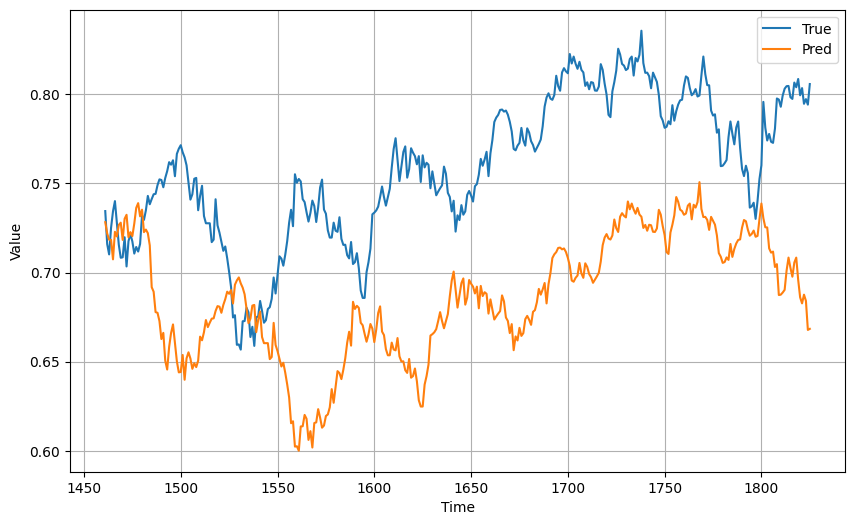

In [110]:
# matplotlib.pyplot 모듈을 임포트합니다. 이 모듈은 그래프를 그리는 데 사용됩니다.
import matplotlib.pyplot as plt

# 그래프의 크기를 설정합니다. 여기서는 가로 10인치, 세로 6인치로 설정합니다.
plt.figure(figsize=(10, 6))

# 시리즈 데이터를 그래프에 플롯하는 함수를 정의합니다.
def plot_series(time, series, format='-', start=0, end=None, label=None):
    # 시간과 시리즈 데이터를 기반으로 라인 플롯을 생성합니다.
    plt.plot(time[start:end], series[start:end], format, label=label)
    # x축 레이블을 'Time'으로 설정합니다.
    plt.xlabel('Time')
    # y축 레이블을 'Value'로 설정합니다.
    plt.ylabel('Value')
    # 범례를 표시합니다. 이는 라벨이 제공된 경우에만 표시됩니다.
    plt.legend()
    # 그리드를 표시합니다. 이는 그래프의 가독성을 높이는 데 도움을 줍니다.
    plt.grid(True)

# 검증 데이터에 대한 실제 시리즈 값을 그래프에 플롯합니다.
plot_series(time_valid, x_valid, label='True')

# 검증 데이터에 대한 예측 시리즈 값을 그래프에 플롯합니다.
plot_series(time_valid, results, label='Pred')

# 그래프를 표시합니다.
plt.show()

In [111]:
# keras.metrics 모듈에서 mean_absolute_error 함수를 임포트합니다.
# 이 함수는 평균 절대 오차(MAE)를 계산하는 데 사용됩니다.
from keras.metrics import mean_absolute_error

# 실제 값(x_valid)과 예측 값(results) 사이의 MAE를 계산합니다.
# mean_absolute_error 함수는 두 배열을 입력으로 받아 MAE 값을 계산합니다.
# .numpy() 메서드를 호출하여 계산된 MAE 값을 NumPy 배열 형태로 변환합니다.
mae = mean_absolute_error(x_valid, results).numpy()

# 계산된 MAE 값을 출력합니다.
print('mae : ', mae)

mae :  0.07391452


In [112]:
#@title 다른 RNN 레이어 써보기

from keras.layers import GRU, LSTM

Epoch 1/50
45/45 [==============================] - 4s 22ms/step - loss: 0.0259 - mae: 0.1481 - val_loss: 1.1087e-04 - val_mae: 0.0118
Epoch 2/50
45/45 [==============================] - 0s 7ms/step - loss: 6.4961e-04 - mae: 0.0286 - val_loss: 9.6337e-05 - val_mae: 0.0114
Epoch 3/50
45/45 [==============================] - 0s 8ms/step - loss: 3.4008e-04 - mae: 0.0213 - val_loss: 9.3669e-05 - val_mae: 0.0112
Epoch 4/50
45/45 [==============================] - 0s 8ms/step - loss: 1.7129e-04 - mae: 0.0144 - val_loss: 6.6748e-05 - val_mae: 0.0091
Epoch 5/50
45/45 [==============================] - 0s 7ms/step - loss: 9.0838e-05 - mae: 0.0099 - val_loss: 6.1646e-05 - val_mae: 0.0088
Epoch 6/50
45/45 [==============================] - 0s 8ms/step - loss: 6.8792e-05 - mae: 0.0083 - val_loss: 5.9295e-05 - val_mae: 0.0087
Epoch 7/50
45/45 [==============================] - 0s 7ms/step - loss: 6.2706e-05 - mae: 0.0079 - val_loss: 6.0265e-05 - val_mae: 0.0087
Epoch 8/50
45/45 [===================

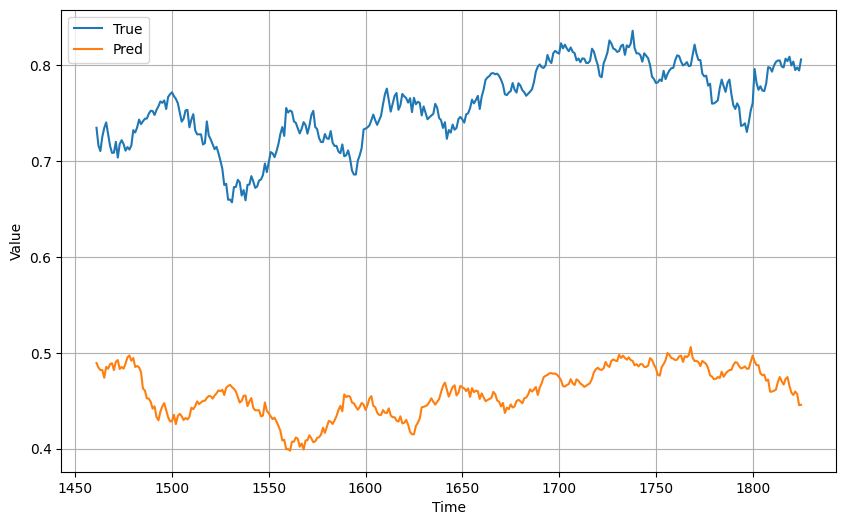

mae :  0.29926458


In [114]:
# 순차 모델을 생성합니다. 이 모델은 레이어를 순차적으로 쌓아 구성됩니다.
model = Sequential([
    # 첫 번째 GRU 레이어를 추가합니다. 64개의 뉴런을 가집니다.
    # return_sequences=True는 다음 레이어로 모든 시간 단계의 출력을 전달합니다.
    # input_shape는 입력 데이터의 형태를 정의합니다. 여기서는 시퀀스의 길이가 정해지지 않았고, 각 시간 단계마다 하나의 특성을 가집니다.
    ,

    # 두 번째 GRU 레이어를 추가합니다. 이 레이어도 64개의 뉴런을 가집니다.
    # 이 레이어는 return_sequences=True가 설정되지 않았으므로, 마지막 시간 단계의 출력만 다음 레이어로 전달합니다.
    ,

    # Dense 레이어는 출력 레이어로, 하나의 뉴런을 가집니다. 이 레이어는 최종 예측 값을 생성합니다.
    Dense(1),
])

optimizer = Adam(learning_rate=0.001)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mae'])
history = model.fit(dataset, epochs=50, verbose=1,
                    validation_data=valid_dataset)

forecast = []

for time in range(len(series) - window_size):
    prediction = model.predict(series[time:time + window_size], verbose=1)
    forecast.append(prediction)

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

def plot_series(time, series, format='-', start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)

plot_series(time_valid, x_valid, label='True')
plot_series(time_valid, results, label='Pred')
plt.show()

print('mae : ', mean_absolute_error(x_valid, results).numpy())

Epoch 1/50
45/45 [==============================] - 4s 23ms/step - loss: 0.0135 - mae: 0.1054 - val_loss: 3.8104e-04 - val_mae: 0.0214
Epoch 2/50
45/45 [==============================] - 0s 8ms/step - loss: 4.7945e-04 - mae: 0.0233 - val_loss: 2.0853e-04 - val_mae: 0.0168
Epoch 3/50
45/45 [==============================] - 0s 7ms/step - loss: 2.4768e-04 - mae: 0.0156 - val_loss: 2.0828e-04 - val_mae: 0.0166
Epoch 4/50
45/45 [==============================] - 0s 8ms/step - loss: 2.0933e-04 - mae: 0.0138 - val_loss: 1.9014e-04 - val_mae: 0.0159
Epoch 5/50
45/45 [==============================] - 0s 7ms/step - loss: 2.1013e-04 - mae: 0.0140 - val_loss: 2.0249e-04 - val_mae: 0.0164
Epoch 6/50
45/45 [==============================] - 0s 7ms/step - loss: 2.1426e-04 - mae: 0.0141 - val_loss: 1.8537e-04 - val_mae: 0.0157
Epoch 7/50
45/45 [==============================] - 0s 7ms/step - loss: 2.0702e-04 - mae: 0.0140 - val_loss: 1.8558e-04 - val_mae: 0.0157
Epoch 8/50
45/45 [===================

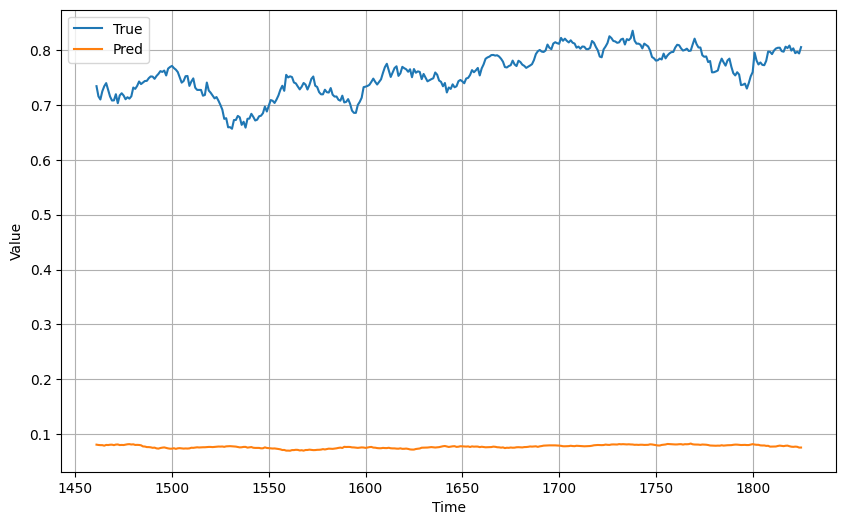

mae :  0.6815112


In [115]:
# 순차 모델을 생성합니다. 이 모델은 레이어를 순차적으로 쌓아 구성됩니다.
model = Sequential([
    # 첫 번째 LSTM 레이어를 추가합니다. 64개의 뉴런을 가집니다.
    # return_sequences=True는 다음 레이어로 모든 시간 단계의 출력을 전달합니다.
    # input_shape는 입력 데이터의 형태를 정의합니다. 여기서는 시퀀스의 길이가 정해지지 않았고, 각 시간 단계마다 하나의 특성을 가집니다.
    ,

    # 두 번째 LSTM 레이어를 추가합니다. 이 레이어도 64개의 뉴런을 가집니다.
    # 이 레이어는 return_sequences=True가 설정되지 않았으므로, 마지막 시간 단계의 출력만 다음 레이어로 전달합니다.
    ,

    # Dense 레이어는 출력 레이어로, 하나의 뉴런을 가집니다. 이 레이어는 최종 예측 값을 생성합니다.
    Dense(1),
])

optimizer = Adam(learning_rate=0.001)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mae'])
history = model.fit(dataset, epochs=50, verbose=1,
                    validation_data=valid_dataset)

forecast = []

for time in range(len(series) - window_size):
    prediction = model.predict(series[time:time + window_size], verbose=1)
    forecast.append(prediction)

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

def plot_series(time, series, format='-', start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)

plot_series(time_valid, x_valid, label='True')
plot_series(time_valid, results, label='Pred')
plt.show()

print('mae : ', mean_absolute_error(x_valid, results).numpy())